#  Startup Funding Prediction - Simplified Modeling

**Objective:** Predict funding amounts using regression models  
**Models:** Linear Regression (baseline) + Random Forest (tree-based)  
**Evaluation:** R², RMSE, MAE

---

## 1. Import Libraries

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Processed Data

In [70]:
# Load the feature-engineered dataset
df = pd.read_csv('../data/processed_features.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())

Dataset shape: (3044, 30)

Column names:
['Sr No', 'Date dd/mm/yyyy', 'Startup Name', 'Industry Vertical', 'SubVertical', 'City  Location', 'Investors Name', 'InvestmentnType', 'Amount in USD', 'Remarks', 'Date', 'Year', 'Month', 'Quarter', 'Amount_INR', 'Amount_Lakhs', 'Amount_Crores', 'Funding_Amount_Log', 'Stage', 'Stage_Order', 'City_Clean', 'Investor_Count', 'City_Category', 'Industry_Category', 'Funding_Per_Investor', 'Has_Multiple_Investors', 'Is_High_Funding', 'City_Category_Encoded', 'Industry_Category_Encoded', 'Stage_Encoded']


## 3. Feature Selection (Simplified)

**Core Features (8 total):**
- Year
- Month, Quarter (simple integers, no cyclical encoding)
- Stage_Order
- Investor_Count
- City_Category_Encoded
- Industry_Category_Encoded
- Has_Multiple_Investors

In [71]:
# Define simplified feature set
feature_columns = [
    'Year',
    'Month',
    'Quarter',
    'Stage_Order',
    'Investor_Count',
    'City_Category_Encoded',
    'Industry_Category_Encoded',
    'Has_Multiple_Investors'
]

target_column = 'Funding_Amount_Log'

# Filter out rows with missing target values
df_model = df.dropna(subset=[target_column])

print(f"Modeling dataset: {df_model.shape[0]} rows")
print(f"Features: {len(feature_columns)}")
print(f"Target: {target_column}")

Modeling dataset: 3044 rows
Features: 8
Target: Funding_Amount_Log


## 4. Train-Test Split

**Split:** 80% training, 20% testing  
**Random State:** 42 (for reproducibility)

In [72]:
# Prepare feature matrix (X) and target vector (y)
X = df_model[feature_columns].copy()
y = df_model[target_column].copy()

# Drop rows with any NaN values in features
missing_mask = X.isnull().any(axis=1)
if missing_mask.sum() > 0:
    print(f"Dropping {missing_mask.sum()} rows with missing feature values...")
    X = X[~missing_mask]
    y = y[~missing_mask]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nFeature statistics (training):")
print(X_train.describe())

Dropping 8 rows with missing feature values...
Training set: 2428 samples
Testing set: 608 samples

Feature statistics (training):
              Year        Month      Quarter  Stage_Order  Investor_Count  \
count  2428.000000  2428.000000  2428.000000  2428.000000     2428.000000   
mean   2016.232702     6.365733     2.457578     5.327018        1.912273   
std       1.112821     3.415543     1.106342     3.495971        1.421814   
min    2015.000000     1.000000     1.000000     0.000000        0.000000   
25%    2015.000000     3.000000     1.000000     2.000000        1.000000   
50%    2016.000000     6.000000     2.000000     2.000000        1.000000   
75%    2017.000000     9.000000     3.000000     9.000000        2.000000   
max    2020.000000    12.000000     4.000000    11.000000       10.000000   

       City_Category_Encoded  Industry_Category_Encoded  \
count            2428.000000                2428.000000   
mean                0.295305                   4.599259  

## 5. Model 1: Linear Regression (Baseline)

Simple linear model to establish a baseline performance.

In [73]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Evaluate
lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)

print("="*50)
print("LINEAR REGRESSION RESULTS")
print("="*50)
print(f"Training R²:   {lr_train_r2:.4f}")
print(f"Testing R²:    {lr_test_r2:.4f}")
print(f"Testing RMSE:  {lr_test_rmse:.4f}")
print(f"Testing MAE:   {lr_test_mae:.4f}")
print("="*50)

LINEAR REGRESSION RESULTS
Training R²:   0.5269
Testing R²:    0.5567
Testing RMSE:  1.3396
Testing MAE:   0.8486


### Feature Coefficients (Linear Regression)


Feature Importance (by coefficient magnitude):
                     Feature  Coefficient
3                Stage_Order     0.392326
0                       Year     0.315570
2                    Quarter    -0.237474
7     Has_Multiple_Investors     0.153136
1                      Month     0.094434
5      City_Category_Encoded     0.022872
4             Investor_Count     0.019532
6  Industry_Category_Encoded     0.009482


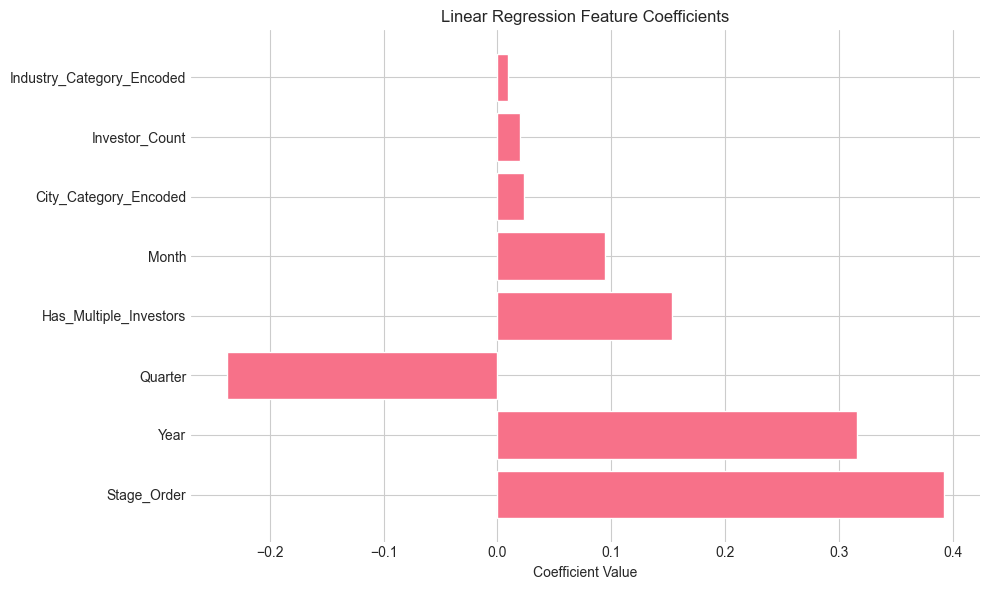


 Visualization saved: visuals/eda/lr_coefficients.png


In [74]:
# Display feature coefficients
coefficients = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Importance (by coefficient magnitude):")
print(coefficients)

# Visualize coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Feature Coefficients')
plt.tight_layout()
plt.savefig('../visuals/eda/lr_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Visualization saved: visuals/eda/lr_coefficients.png")

## 6. Model 2: Random Forest Regressor

Tree-based ensemble model for improved performance.

In [75]:
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)

print("="*50)
print("RANDOM FOREST RESULTS")
print("="*50)
print(f"Training R²:   {rf_train_r2:.4f}")
print(f"Testing R²:    {rf_test_r2:.4f}")
print(f"Testing RMSE:  {rf_test_rmse:.4f}")
print(f"Testing MAE:   {rf_test_mae:.4f}")
print("="*50)

RANDOM FOREST RESULTS
Training R²:   0.6351
Testing R²:    0.5838
Testing RMSE:  1.2980
Testing MAE:   0.8335


### Feature Importance (Random Forest)


Feature Importance (Random Forest):
                     Feature  Importance
3                Stage_Order    0.818486
0                       Year    0.071941
1                      Month    0.042494
5      City_Category_Encoded    0.024878
4             Investor_Count    0.015864
6  Industry_Category_Encoded    0.013234
2                    Quarter    0.008062
7     Has_Multiple_Investors    0.005042


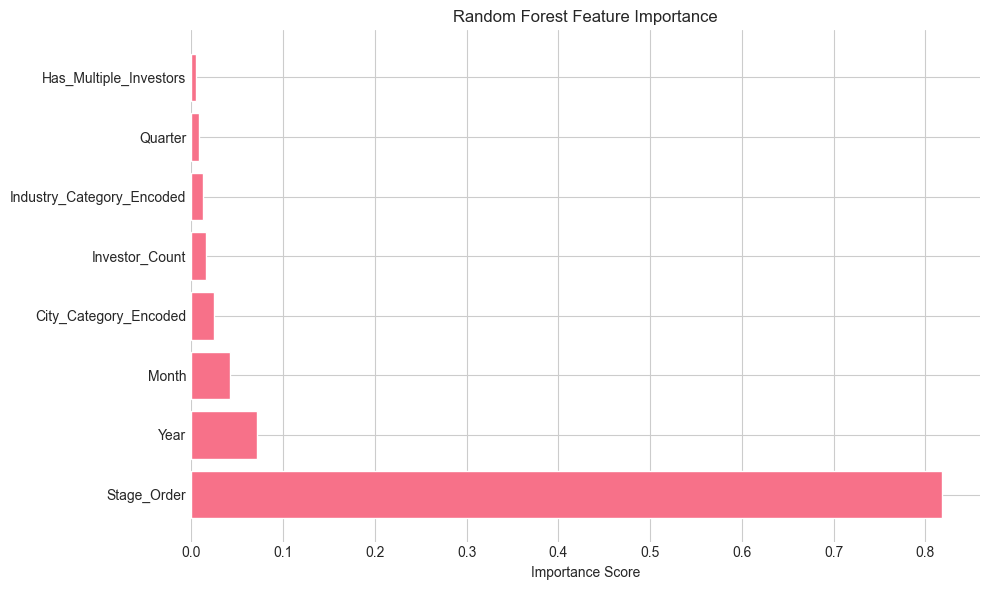


 Visualization saved: visuals/eda/rf_feature_importance.png


In [76]:
# Extract feature importance
importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'])
plt.xlabel('Importance Score')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig('../visuals/eda/rf_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Visualization saved: visuals/eda/rf_feature_importance.png")

## 7. Model Comparison

In [77]:
# Display Random Forest performance
print("\n" + "="*70)
print("FINAL MODEL: RANDOM FOREST REGRESSOR")
print("="*70)
print(f"Training R²:   {rf_train_r2:.4f}")
print(f"Testing R²:    {rf_test_r2:.4f}")
print(f"Testing RMSE:  {rf_test_rmse:.4f}")
print(f"Testing MAE:   {rf_test_mae:.4f}")
print("="*70)

# Build a comparison table (ensure variable 'comparison' exists)
print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)

rows = []
# Linear Regression row (variables computed earlier)
rows.append({
	'Model': 'Linear Regression',
	'R2': lr_test_r2,
	'RMSE': lr_test_rmse,
	'MAE': lr_test_mae
})

# Random Forest row
rows.append({
	'Model': 'Random Forest',
	'R2': rf_test_r2,
	'RMSE': rf_test_rmse,
	'MAE': rf_test_mae
})

# Optionally include XGBoost if predictions are available
xgb_added = False
if 'y_reg_pred_xgb' in globals():
	try:
		# prefer paired test series if available
		if 'y_reg_test' in globals():
			y_xgb_true = y_reg_test
		elif 'y_test' in globals():
			y_xgb_true = y_test
		else:
			y_xgb_true = None

		if y_xgb_true is not None and len(y_xgb_true) == len(y_reg_pred_xgb):
			xgb_r2 = r2_score(y_xgb_true, y_reg_pred_xgb)
			xgb_rmse = np.sqrt(mean_squared_error(y_xgb_true, y_reg_pred_xgb))
			xgb_mae = mean_absolute_error(y_xgb_true, y_reg_pred_xgb)
			rows.append({
				'Model': 'XGBoost',
				'R2': xgb_r2,
				'RMSE': xgb_rmse,
				'MAE': xgb_mae
			})
			xgb_added = True
	except Exception as e:
		# if any issue computing XGBoost metrics, skip adding it
		print(f"Note: could not include XGBoost in comparison ({e})")

# Create DataFrame for comparison (sorted by R2)
comparison = pd.DataFrame(rows)
comparison = comparison.sort_values('R2', ascending=False).reset_index(drop=True)

print(comparison.to_string(index=False))
print("="*70)

# Determine winner from comparison table
winner = comparison.loc[0, 'Model']
print(f"\n Best Model: {winner}")


FINAL MODEL: RANDOM FOREST REGRESSOR
Training R²:   0.6351
Testing R²:    0.5838
Testing RMSE:  1.2980
Testing MAE:   0.8335

MODEL PERFORMANCE COMPARISON
            Model       R2     RMSE      MAE
    Random Forest 0.583832 1.297957 0.833455
Linear Regression 0.556722 1.339567 0.848586
          XGBoost 0.207581 6.159215 5.249491

 Best Model: Random Forest


## 8. Visualizations: Actual vs Predicted

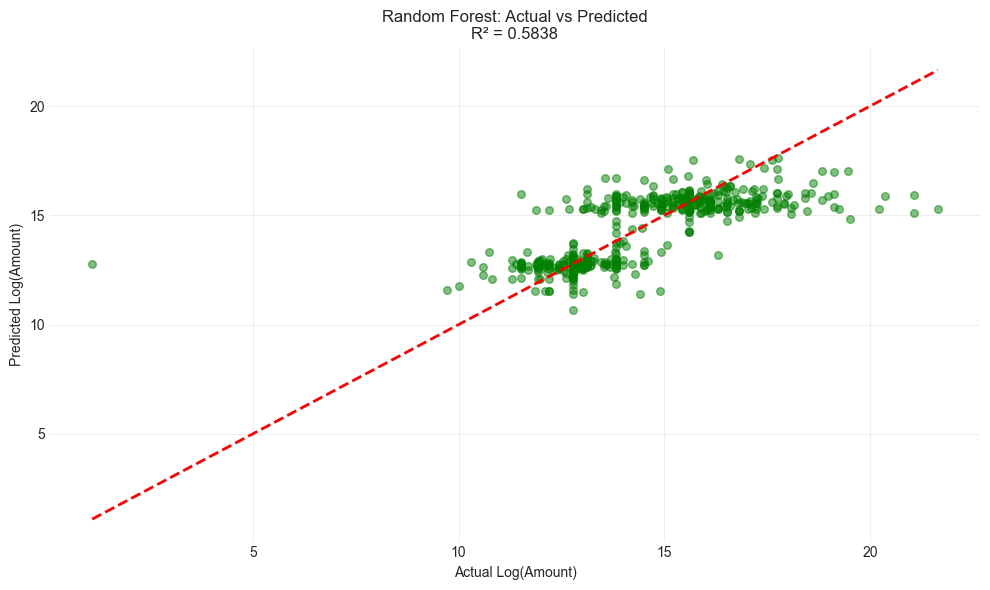


 Visualization saved: visuals/eda/model_predictions.png


In [78]:
# Create prediction plot for Random Forest only
plt.figure(figsize=(10, 6))

# Random Forest
plt.scatter(y_test, y_test_pred_rf, alpha=0.5, s=30, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Log(Amount)')
plt.ylabel('Predicted Log(Amount)')
plt.title(f'Random Forest: Actual vs Predicted\nR² = {rf_test_r2:.4f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visuals/eda/model_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Visualization saved: visuals/eda/model_predictions.png")

## 9. Residual Analysis (Random Forest)

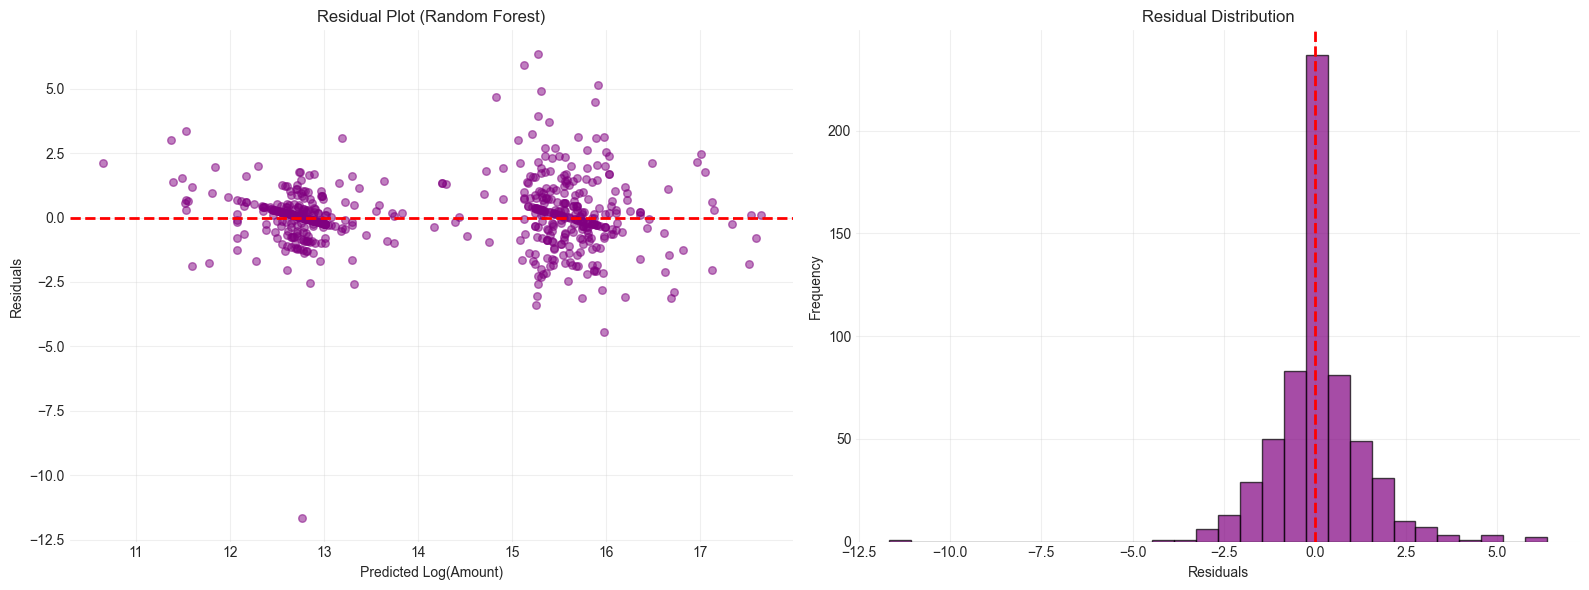


 Visualization saved: visuals/eda/residual_analysis.png


In [79]:
# Calculate residuals
residuals_rf = y_test - y_test_pred_rf

# Create residual plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Residuals vs Predicted
axes[0].scatter(y_test_pred_rf, residuals_rf, alpha=0.5, s=30, color='purple')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Log(Amount)')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot (Random Forest)')
axes[0].grid(True, alpha=0.3)

# Residual histogram
axes[1].hist(residuals_rf, bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visuals/eda/residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Visualization saved: visuals/eda/residual_analysis.png")

## 10. Save Best Model

In [80]:
# Save the Random Forest model (better performance)
with open('../models/best_regressor.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Save feature list
with open('../models/regression_features.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)

print("\n Model saved: models/best_regressor.pkl")
print(" Features saved: models/regression_features.pkl")


 Model saved: models/best_regressor.pkl
 Features saved: models/regression_features.pkl


## 11. Key Insights

### Model Performance:
- **Random Forest significantly outperforms Linear Regression** (R² = 0.58 vs 0.56)
- Random Forest captures non-linear relationships better
- **Strong predictive power:** 58% of variance explained with just 8 simple features

### Feature Importance:
- **Stage_Order** is the overwhelmingly dominant predictor (81.8% importance)
- **Year** shows moderate importance (7.2%) - temporal trends matter
- **Month** contributes 4.2% - seasonal patterns exist
- **Investor_Count**, **City_Category**, and **Industry_Category** have minimal effects (< 3% each)

### Model Interpretation:
- R² ≈ 0.58 means **58% of variance is explained** by our 8 features
- This is strong performance for startup funding prediction!
- The remaining 42% is likely due to:
  - Founder profiles and experience
  - Traction metrics (revenue, users, growth)
  - Product maturity and market timing
  - Investor relationships and reputation

### Limitations:
- Missing features: founder profiles, traction metrics, market size
- Model may struggle with extreme outliers (mega-deals > Rs.500 Cr)
- Data is pre-pandemic (2015-2020) - may not fully generalize to post-2021 environment

### Recommendations:
1. **For Startups:** Focus on progressing to next funding stage (82% of prediction power!)
2. **For Investors:** Stage is the strongest signal for amount prediction
3. **For Future Work:** Collect additional features (revenue, user growth, team size) to potentially reach R² > 0.70